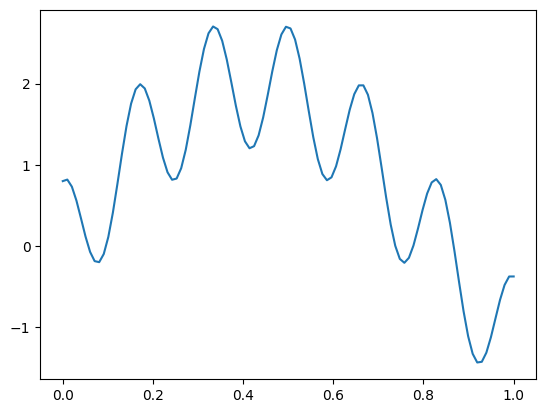

In [1]:
import torch
import matplotlib.pyplot as plt

objective = lambda x: 2 * torch.sin(3.14 * 1.2 * x) + 0.8 * torch.cos(3.14 * 12 * x)

test_x = torch.linspace(0, 1, 100)
test_y = objective(test_x)
plt.plot(test_x, test_y)

In [2]:
import torch.utils
import torch.utils.data
from src.dl.resnet import CustomResNet
import torchvision
from tqdm import tqdm

torch.set_num_threads(16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def objective(lr):
    torch.manual_seed(0)
    epochs = 20
    model = CustomResNet().to(device)
    optim = torch.optim.Adam(model.parameters(), lr.item())
    criterion = torch.nn.CrossEntropyLoss()

    dataset = torchvision.datasets.FashionMNIST(
        root="data/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
    )
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=512,
        shuffle=False,
        num_workers=16,
        prefetch_factor=2,
        persistent_workers=True,
    )
    for _ in tqdm(range(epochs), desc="Epochs", leave=False, disable=False):
        for batch in tqdm(data_loader, desc="Batches", leave=False, disable=True):
            optim.zero_grad()
            inputs, targets = batch
            logits = model(inputs.to(device))
            loss = criterion(logits, targets.to(device))
            loss.backward()
            optim.step()

    del optim
    del dataset
    del data_loader

    dataset_test = torchvision.datasets.FashionMNIST(
        root="data/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
    )
    data_loader = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=2048,
        shuffle=False,
        num_workers=16,
        prefetch_factor=2,
        persistent_workers=True,
    )
    # test_loss = torch.tensor(0).to(device).double()
    correct = 0
    for batch in tqdm(data_loader, desc="Testing", leave=False, disable=False):
        inputs, targets = batch
        logits = model(inputs.to(device))
        # loss = criterion(logits, targets.to(device))
        correct += logits.argmax(-1).eq(targets.to(device)).sum()
    accuracy = correct / len(dataset_test)
    del dataset_test
    del data_loader
    # return -test_loss.unsqueeze(0).detach().cpu().double()  # return inverse of last loss
    return accuracy.unsqueeze(0).detach().cpu().double()  # return inverse of last loss


objective(torch.tensor(0.02))

tensor([0.9091], dtype=torch.float64)

(0.0, 1.0)

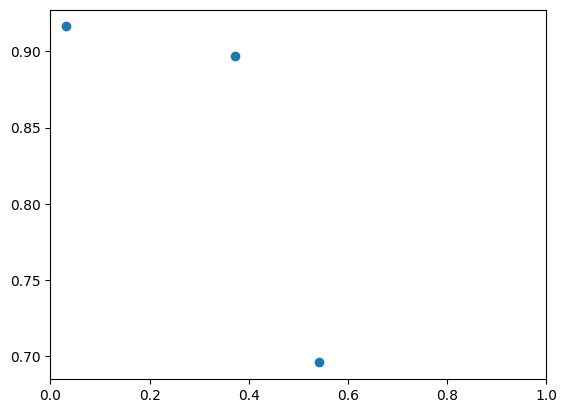

In [3]:
train_x = torch.zeros(3).double()
train_y = torch.zeros(3).double()
sobol = torch.quasirandom.SobolEngine(1, scramble=True)

for i in range(3):
    lr = sobol.draw(1)[0].double()
    train_x[i] = lr.item()
    train_y[i] = objective(lr).item()
plt.scatter(train_x, train_y)
plt.xlim(0, 1)
# plt.plot(test_x, test_y, "--")

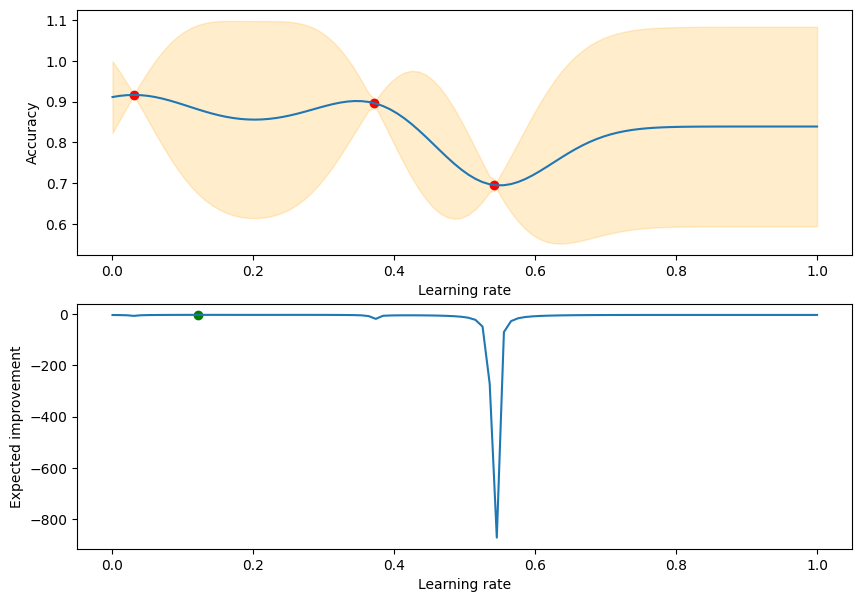

tensor(0.1221)


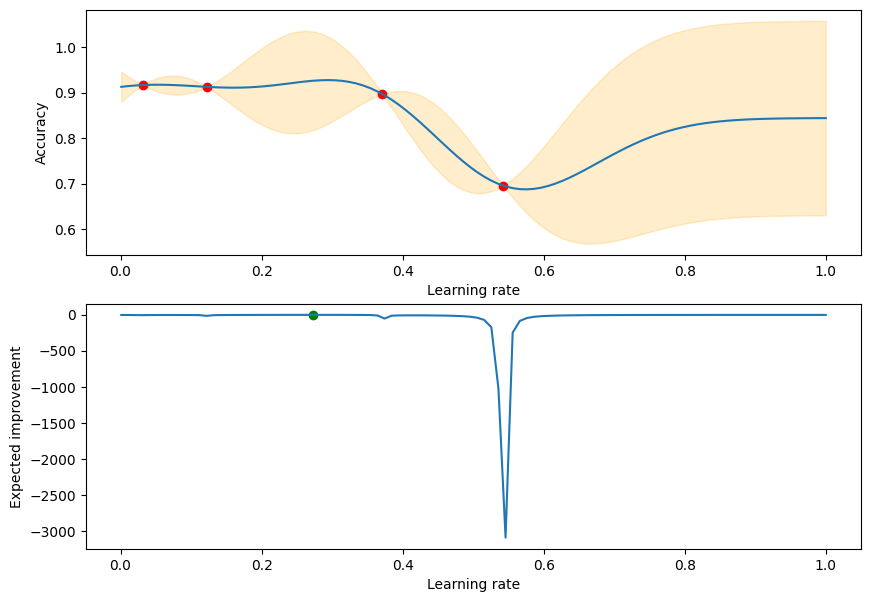

tensor(0.2735)


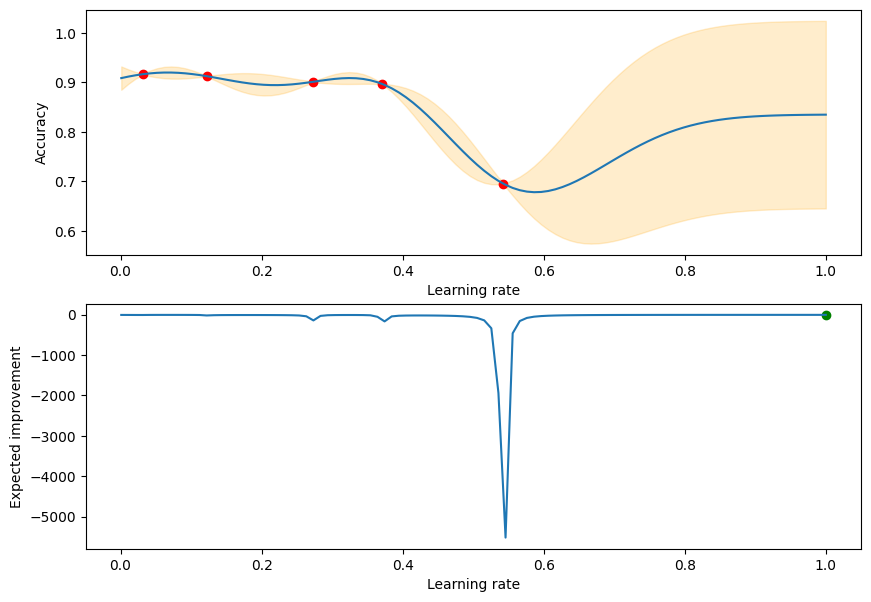

tensor(1.)


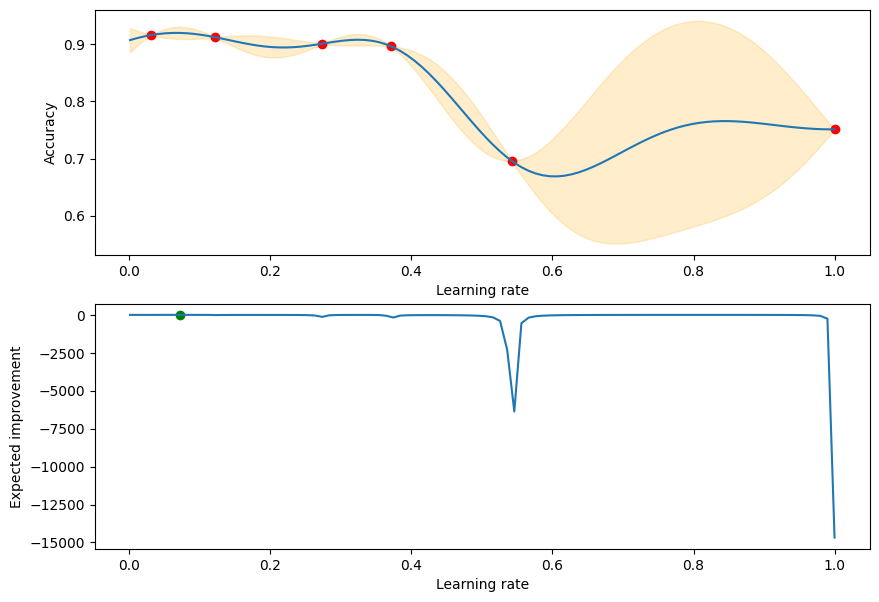

tensor(0.0716)


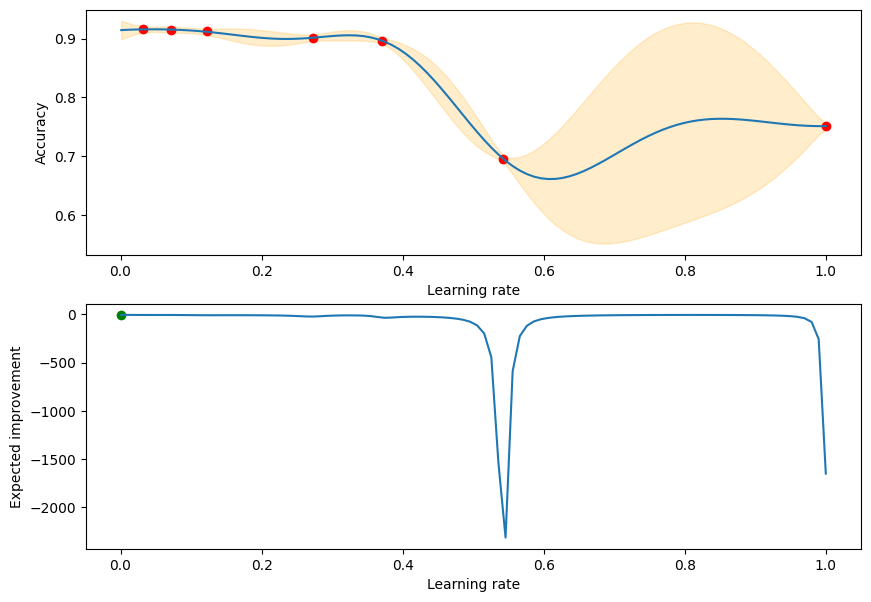

tensor(0.0010)


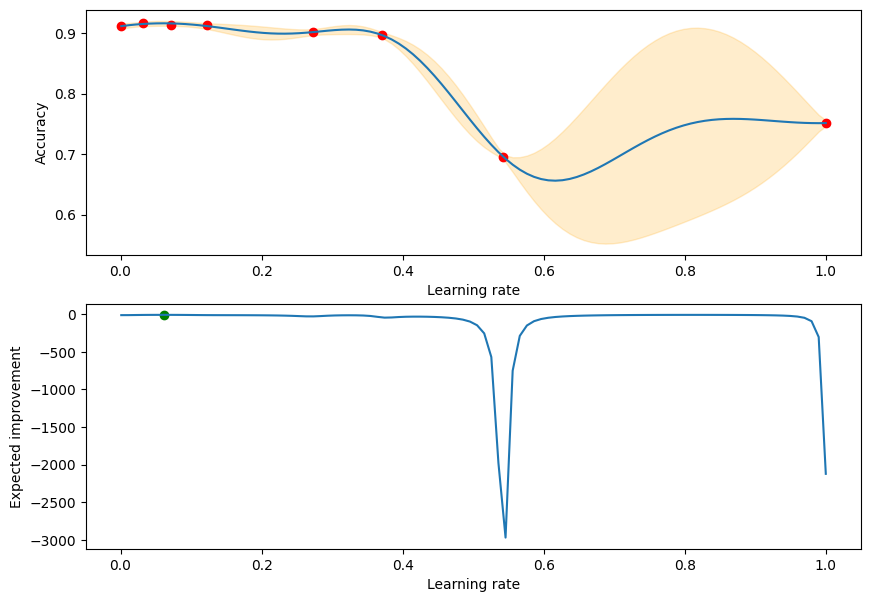

tensor(0.0615)


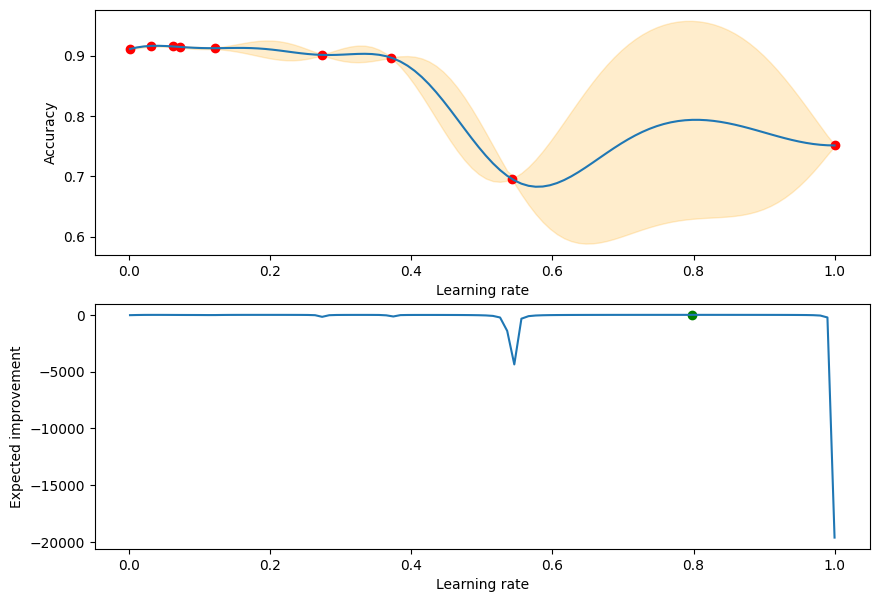

tensor(0.7982)


In [ ]:
import warnings
from botorch.acquisition import LogExpectedImprovement, ExpectedImprovement
from src.bayesian_optim.gaussian_process import GaussianProcess

train_x = train_x[:3]  # just incase we rerun
train_y = train_y[:3]

warnings.filterwarnings("ignore")

gp_trainer = GaussianProcess()
for _ in range(7):
    grid = torch.linspace(0.001, 1, steps=100).unsqueeze(-1).unsqueeze(-1)

    # GP inference
    gp = gp_trainer.fit(
        train_x=train_x,
        train_y=train_y,
    )

    posterior = gp.posterior(grid)
    mean = posterior.mean.detach().squeeze(-1).squeeze(-1)
    std = posterior.variance.sqrt().detach().squeeze(-1).squeeze(-1)

    # Calculate expected improvement and next LR
    ei = LogExpectedImprovement(model=gp, best_f=train_y.max())
    ei_val = ei(grid)
    next_x = grid[ei_val.argmax()][0].double()
    next_y = objective(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

    # Plotting
    plt.figure(figsize=(10, 7))

    plt.subplot(2, 1, 1)
    plt.plot(grid[:, 0, 0], mean)
    plt.fill_between(
        grid[:, 0, 0], mean - 2 * std, mean + 2 * std, alpha=0.2, color="orange"
    )
    plt.xlabel("Learning rate")
    plt.ylabel("Accuracy")
    plt.scatter(train_x[:-1], train_y[:-1], color="red")
    # plt.plot(test_x, test_y, "--", color="black", alpha=0.3)

    plt.subplot(2, 1, 2)

    plt.plot(grid[:, 0, 0], ei_val.detach())
    plt.scatter(grid[ei_val.argmax(0), 0, 0], ei_val.detach().max(), color="green")
    plt.xlabel("Learning rate")
    plt.ylabel("Expected improvement")
    plt.show()

    print(grid[ei_val.argmax(0), 0, 0])